In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.spatial import distance
from sklearn.decomposition import PCA
import math
from sklearn import preprocessing  # to normalise existing X
import random
from scipy.spatial.distance import pdist,squareform
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap
from sklearn.decomposition import KernelPCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn import mixture
from sklearn.manifold import TSNE, MDS
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import LocallyLinearEmbedding, SpectralEmbedding

### Functions

In [12]:
def mds_reduction(data, target_dimension):
  return pd.DataFrame(MDS(n_components=target_dimension,eps=1e-4,n_init=15).fit_transform(data))
#PCA get principal components Functions
def get_pca(x):
    pca = PCA(n_components = d)
    pca.fit_transform(x)
    print(pca.explained_variance_ratio_)
    return pca.explained_variance_ratio_, pca.components_
#Identifying Components with small Eigenvalue
THRESHOLD = 0.99
def find_normal_vectors(eigens, vectors):
  res = sum(eigens)
  current = 0
  normal_vectors = []
  for i in range(0,len(eigens)):
    current += eigens[i]
    if current/res > THRESHOLD:
      for j in range(i+1,len(eigens)):
        normal_vectors.append(vectors[j])
      break
  return normal_vectors
def normalized(X, c):
  for i in range(len(X)):
    X.iloc[i]-= c
  return preprocessing.normalize(X)
def variance(data):
  mean = sum(data) / len(data)
  deviations = [(x - mean) ** 2 for x in data]
  variance = sum(deviations) / len(data)
  return variance
def get_reduced(X, target_dimension, reduction_type):
  X_transformed = []
  if reduction_type == 'iso':
    embedding = Isomap(n_components=target_dimension, n_neighbors=10)
    X_transformed = embedding.fit_transform(X)
  elif reduction_type == 'pca':
    transformer = PCA(n_components=target_dimension)
    X_transformed = transformer.fit_transform(X)
  elif reduction_type == 'k-pca':
    transformer = KernelPCA(n_components=target_dimension, kernel='rbf')
    X_transformed = transformer.fit_transform(X)
  elif reduction_type == 'tsne':
    X_transformed = TSNE(n_components=target_dimension, learning_rate='auto', init='pca').fit_transform(manifold_list[i])
  elif reduction_type == 'mds':
    X_transformed = mds_reduction(manifold_list[i],target_dimension)
  elif reduction_type == 'LLE':
    X_transformed = LocallyLinearEmbedding(n_components=target_dimension, n_neighbors=30).fit_transform(manifold_list[i])
  return X_transformed
def get_cluster(X, num_cluster, cluster_type):
  if cluster_type == 'GMM':
    model = mixture.GaussianMixture(n_components=num_cluster, covariance_type='full', n_init=100)
    model.fit(X)
    labels = model.predict(X)
  elif cluster_type == 'k-means':
    model=KMeans(n_clusters=num_cluster, n_init=10, max_iter=10000)
    model.fit(X)
    labels = model.predict(X)
  elif cluster_type == 'HS':
    model = AgglomerativeClustering(n_clusters=num_cluster, linkage='single')
    model.fit(X)
    labels = model.labels_
  elif cluster_type == 'H':
    model = AgglomerativeClustering(n_clusters=num_cluster, linkage='single', affinity='cosine')
    model.fit(X)
    labels = model.labels_
  elif cluster_type == 'spectral':
    model = SpectralClustering(assign_labels='discretize', n_clusters=num_cluster, random_state=77, n_init=1)
    model.fit(X)
    labels = model.labels_
  return labels
# Epsilon for DBSCAN
def show_distance_graph(X):
  neigh = NearestNeighbors(n_neighbors=5)
  nbrs = neigh.fit(X)
  distances, indices = nbrs.kneighbors(X)
  # Plotting K-distance Graph
  distances = np.sort(distances, axis=0)
  distances = distances[:,1]
  print(distances[-40:])
  plt.figure(figsize=(10,5))
  plt.plot(distances)
  plt.title('K-distance Graph',fontsize=20)
  plt.xlabel('Data Points sorted by distance',fontsize=14)
  plt.ylabel('Epsilon',fontsize=14)
  plt.show()
  #Visualization in 4D
%matplotlib notebook
def visualize_4d(frame, hot=True):
  fig = plt.figure(figsize=(7, 7))
  ax = fig.add_subplot(111, projection='3d')
  x = np.array(frame.iloc[:,0])
  if len(frame.columns) > 1:
    y = np.array(frame.iloc[:,1])
  if len(frame.columns) > 2:
    z = np.array(frame.iloc[:,2])
  if len(frame.columns) == 1:
    img = ax.scatter(x, x, s=2)
  if len(frame.columns) == 2:
    img = ax.scatter(x, y, s=2)
  elif len(frame.columns) == 3:
    img = ax.scatter(x, y, z, s=2)
  else:
    c = np.array(frame.iloc[:,3])
    if hot:
      img = ax.scatter(x, y, z, c=c, cmap=plt.hot(), s=2)
    else:
      img = ax.scatter(x, y, z, c=c, cmap='viridis', s=2)
  plt.show()

### Open Input

In [13]:
# Input
subset = 2
file = open(f'./R3{subset}.txt','r')
d,n,m,k,p = list(map(int,file.readline().split()))
k_list = list(map(int,file.readline().split()))
ar = []
for i in range(0,n):
  ar.append(list(map(float,file.readline().split())))
df= pd.DataFrame(ar)
df.describe()

,0,1,2
count,44324.000000,44324.000000,44324.000000
mean,182.349928,1.342918,-39.917979
std,116.873990,36.831553,45.692265
min,-275.209367,-96.416813,-169.455848
25%,84.368103,-23.156005,-52.041092
50%,162.139744,7.665577,-28.707296
75%,283.031375,32.211882,-8.821529
max,396.826105,88.934881,132.303630


### Finding Submanifolds

In [14]:
#DBSCAN
EPS = 3.2
MIN_SAMPLES = 4
model_name = 'dbscan'
model = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES)
model.fit(df[[i for i in range(d)]])
df['manifold'] = model.labels_
print(df.describe())
visualize_4d(df, hot=False)

                  0             1             2      manifold
count  44324.000000  44324.000000  44324.000000  44324.000000
mean     182.349928      1.342918    -39.917979      6.854503
std      116.873990     36.831553     45.692265      3.634078
min     -275.209367    -96.416813   -169.455848     -1.000000
25%       84.368103    -23.156005    -52.041092      4.000000
50%      162.139744      7.665577    -28.707296      6.000000
75%      283.031375     32.211882     -8.821529     10.000000
max      396.826105     88.934881    132.303630     13.000000


<IPython.core.display.Javascript object>

In [15]:
tmp = df[df['manifold'] == 5][[i for i in range(d)]]
td = 3
res = LocallyLinearEmbedding(n_components=td, n_neighbors=20).fit_transform(tmp)
p = pd.DataFrame(res, columns = [i for i in range(td)], index = [i for i in range(len(res))])
tmp['sub0'] = get_cluster(p, num_cluster=2, cluster_type='HS')
tmp2 = tmp[tmp['sub0'] == 0][[i for i in range(d)]]
tmp2['sub1'] = DBSCAN(eps=0.3, min_samples=6).fit_predict(tmp2)
tmp3 = tmp2[tmp2['sub1'] == -1][[i for i in range(d)]]
tmp3['sub2'] = DBSCAN(eps=1.3, min_samples=6).fit_predict(tmp3)

tmp2.loc[tmp2['sub1'] == -1, 'sub2'] = tmp3.sub2.astype(int)
tmp2['cluster'] = tmp2.apply(lambda row : 0 if row['sub1'] == -1 and row['sub2'] == 0 else 1, axis=1)
tmp.loc[tmp['sub0'] == 0, 'sub1'] = tmp2['cluster']
tmp['res'] = tmp.sub0.astype(str) + '-' + tmp.sub1.astype(str)
tmp['res'] = LabelEncoder().fit_transform(tmp['res'])
tmp = tmp.drop(['sub0', 'sub1'], axis=1)

res = df.copy()
res.loc[df['manifold'] == 5, 'subb'] = tmp['res']
res['manifold'] =  res.manifold.astype(str) + '-' + res.subb.astype(str)
res['manifold'] = LabelEncoder().fit_transform(res['manifold'])
res = res.drop(['subb'], axis=1)
# print(res.describe())
plt.close('all')
res['manifold'] -= 1
df = res
print(df.describe())

                  0             1             2      manifold
count  44324.000000  44324.000000  44324.000000  44324.000000
mean     182.349928      1.342918    -39.917979      7.467783
std      116.873990     36.831553     45.692265      4.561059
min     -275.209367    -96.416813   -169.455848     -1.000000
25%       84.368103    -23.156005    -52.041092      3.000000
50%      162.139744      7.665577    -28.707296      7.000000
75%      283.031375     32.211882     -8.821529     12.000000
max      396.826105     88.934881    132.303630     15.000000


In [16]:
# visualize_4d(df.loc[(df['manifold'] == 7) | (df['manifold'] == 1)], hot=False)
res = df.copy()
print(res)
res['manifold'] = res.apply(lambda row: 100 if row['manifold'] == 1 or row['manifold'] == 6 else row['manifold'], axis=1)
res['manifold'] = LabelEncoder().fit_transform(res['manifold'])
res['manifold'] -= 1
df = res
print(df.describe())

                0          1           2  manifold
0        4.038356   8.332329   33.495038         0
1       38.707094  32.329984  -47.445276         1
2       47.443948  25.081677  -23.168038         6
3       37.472773  35.784480  -46.319106         1
4       18.691821  -3.111489   20.779171         7
...           ...        ...         ...       ...
44319  339.640080 -25.311164 -109.181298         3
44320  297.272899   3.794601  -67.446272        15
44321  154.044626 -14.388076   26.611672        12
44322  393.643109 -73.033104 -157.192463         5
44323  393.875662 -85.682589 -147.331696         5

[44324 rows x 4 columns]
                  0             1             2      manifold
count  44324.000000  44324.000000  44324.000000  44324.000000
mean     182.349928      1.342918    -39.917979      7.416907
std      116.873990     36.831553     45.692265      4.537736
min     -275.209367    -96.416813   -169.455848     -1.000000
25%       84.368103    -23.156005    -52.041092     

In [17]:
# visualize_4d(df[df['manifold'] == 1])
res = df.copy()
res.loc[res['manifold'] == 1, 'subb'] = get_cluster(res[res['manifold'] == 1][[i for i in range(d)]], num_cluster=2, cluster_type='HS')
res['manifold'] = res.manifold.astype(str) + '-' + res.subb.astype(str)
res['manifold'] = LabelEncoder().fit_transform(res['manifold'])
res = res.drop(['subb'], axis=1)
res['manifold'] -= 1
print(res.describe())
visualize_4d(res)
df = res

                  0             1             2      manifold
count  44324.000000  44324.000000  44324.000000  44324.000000
mean     182.349928      1.342918    -39.917979      7.684798
std      116.873990     36.831553     45.692265      4.307478
min     -275.209367    -96.416813   -169.455848     -1.000000
25%       84.368103    -23.156005    -52.041092      4.000000
50%      162.139744      7.665577    -28.707296      7.000000
75%      283.031375     32.211882     -8.821529     11.000000
max      396.826105     88.934881    132.303630     15.000000


<IPython.core.display.Javascript object>

0


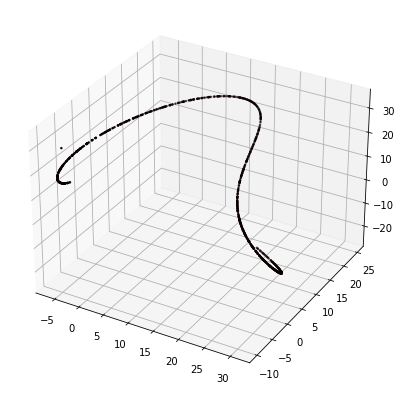

1


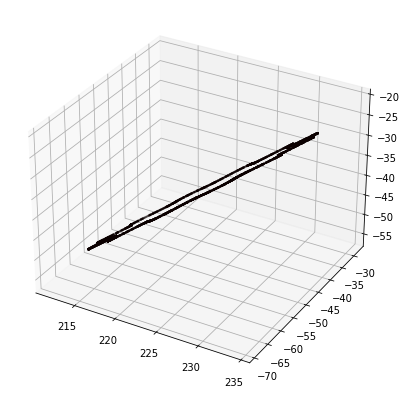

2


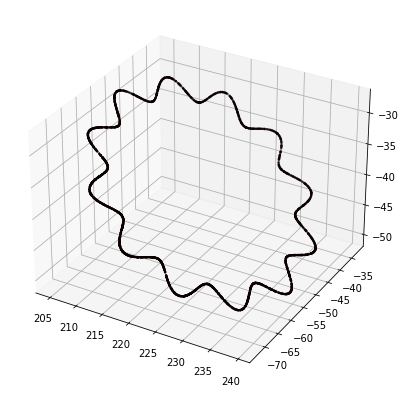

3


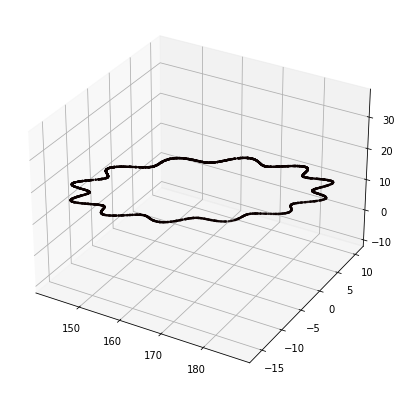

4


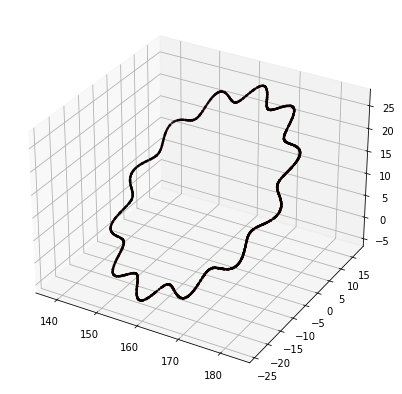

5


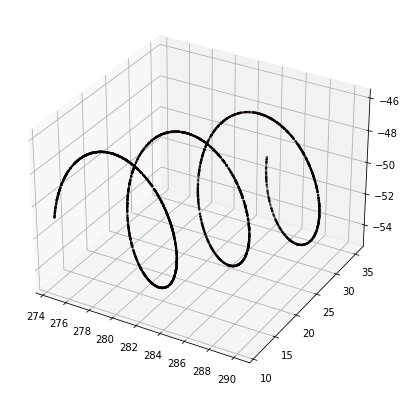

6


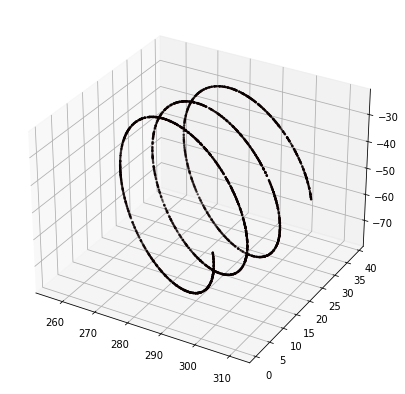

7


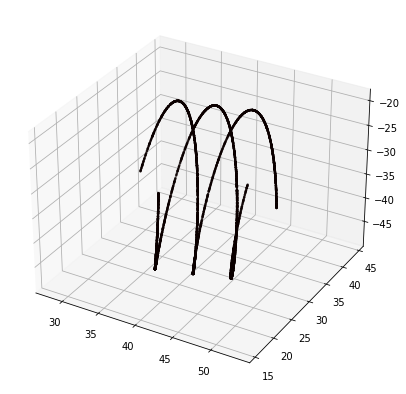

8


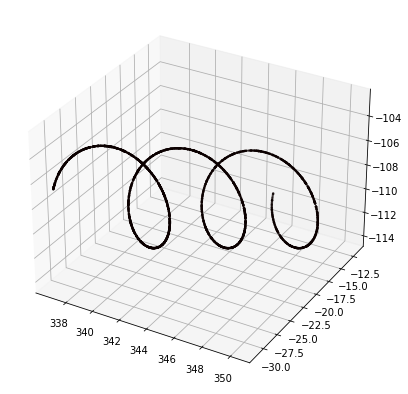

9


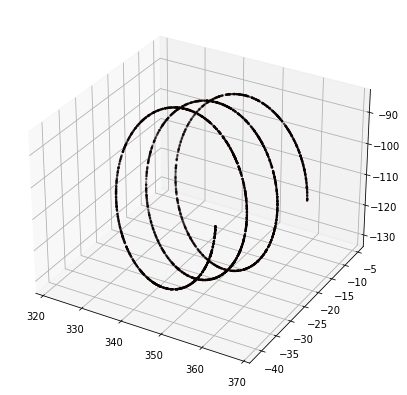

10


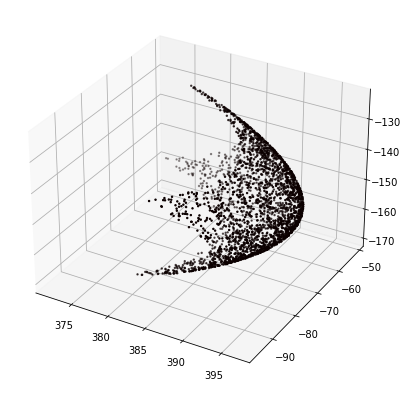

11


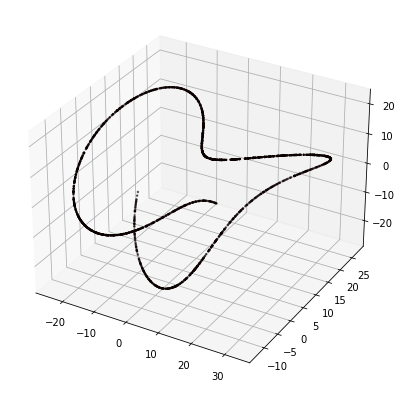

12


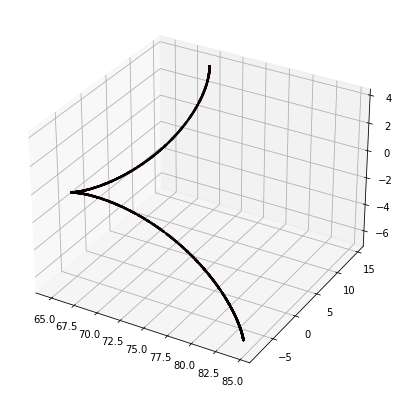

13


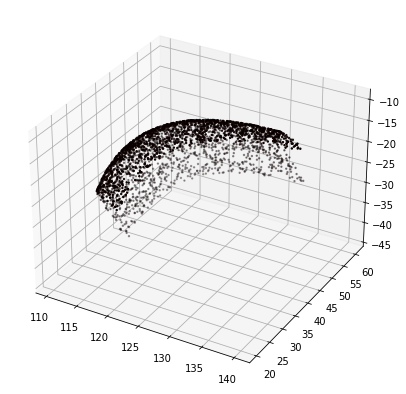

14


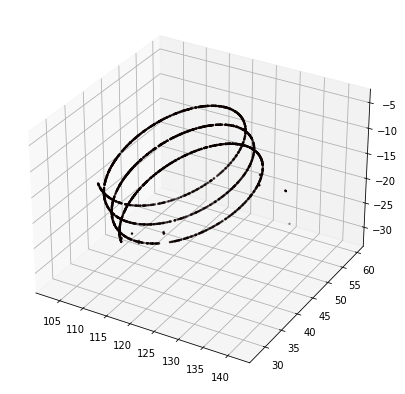

15


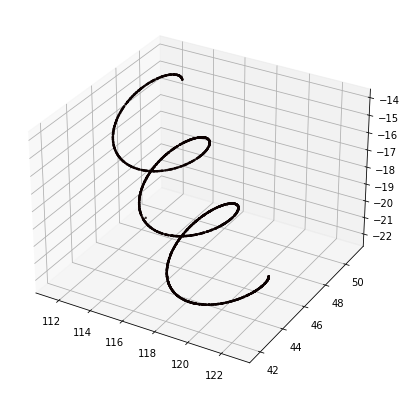

In [25]:
%matplotlib inline
for i in range(m):
  print(i)
  visualize_4d(df[df['manifold'] == i])

In [19]:
# custom cluster for manifold
final_k_list = [1] * 7 + [3] + [1] * 8
cluster_type = ['H'] * 7 + ['HS'] * 3 + ['H'] * 6

In [20]:
# Joining the cluster labeling
def join_clusters():
  df['cluster'] = [0]*n
  data_index = [0] * m
  for i in range(n):
    index_manifold = df.at[i,'manifold']
    if index_manifold!=-1:
      df.at[i,'cluster'] = list_labels[index_manifold][data_index[index_manifold]]
      data_index[index_manifold]+=1

single_run = None
list_labels = []
for i in range(m):
  print(i)
  labels = get_cluster(df[df['manifold'] == i][[i for i in range(d)]], num_cluster=final_k_list[i], cluster_type=cluster_type[i])
  list_labels.append(labels)
join_clusters()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [21]:
visualize_4d(df[df['manifold'] == 7][[0,1,2,'cluster']])

<IPython.core.display.Javascript object>

In [22]:
plt.close('all')
for i in range(12, 16):
  print(i)
  visualize_4d(df[df['manifold'] == i])
D = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1]

12


<IPython.core.display.Javascript object>

13


<IPython.core.display.Javascript object>

14


<IPython.core.display.Javascript object>

15


<IPython.core.display.Javascript object>

### Output

In [23]:
# Outputting

vectors = [[[] for j in range(0,final_k_list[i])] for i in range(0,m)]
#df.loc[df['column_name'] == some_value]
outliar = []
for i in range(n):
  if df.at[i, 'manifold'] == -1:
    outliar.append(i + 1)
  else:
    vectors[df.at[i, 'manifold']][df.at[i, 'cluster']].append(i + 1)

with open('./output.txt', 'w') as f:
  print(f'{n} {m}', file=f)
  for i in range(m):
    dimension = D[i]
    print(f'{dimension} ' + str(final_k_list[i]) + ' Complex', file=f)
    #for j in range(0,len(A[i])):
    #  print(' '.join(list(map(str,A[i][j]))), file=f)
    #print(' '.join(list(map(str,B[i]))), file=f)
    #print(' '.join(list(map(str, centroids[i]))) + ' ' + str(radius[i]), file=f)
    for j in range(0,final_k_list[i]):
      print(str(len(vectors[i][j])) + ' ' + ' '.join(list(map(str, vectors[i][j]))), file=f)
  print(str(len(outliar)) + ' ' + ' '.join(list(map(str, outliar))), file=f)

